In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from datasets import load_dataset, concatenate_datasets
import json
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt
import math


/home/hshapour/.pyenv/versions/3.10.12/envs/pytorch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        # wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class Encoder(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, 2)

        # better init, not covered in the original GPT video, but important, will cover in followup video
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.001)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.001)

    def forward(self, idx, targets=None):
        # idx = idx_in[:,:(d+1)**2+4*d]
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        # x = torch.sum(x, dim=1) # (B,C)
        # num_token = (d_max+1)**2
        # last_token = T +1 - torch.sum( idx == 3, dim = -1)
        # x = x[torch.arange(B),last_token,:]
        x = x[:,-1,:]
        logits = self.lm_head(x) # (B,vocab_size)
        y = F.sigmoid(logits)

        if targets is None:
            loss = None
        else:
            eps = 1e-9
            loss = -torch.sum((targets*torch.log(y+eps)+(1-targets)*torch.log(1-y+eps)).mean(dim=0))
        return y, loss




In [7]:
# hyperparameters
batch_size = 900 # how many independent sequences will we process in parallel?
block_size = 400 # what is the maximum context length for predictions?
max_iters = 5000
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_embd = 128 #384
n_head = 4
n_layer = 6
dropout = 0.2
vocab_size = 4
# ------------

d_max = 9
d = 9 # must be an odd number
model = Encoder()
m = model.to(device)

# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters()), 'parameters')

p_err_train = 0.1
p_err_val = 0.15
dataset = load_dataset("json", data_files={
        'train' : f"datasets/train_eos_original_mixed_{d_max}_p_{p_err_train:.2f}.json",
        'val' : f"datasets/val_eos_original_mixed_{d_max}_p_{p_err_val:.2f}.json"
        # 'train' : f"datasets/train_eos_original_d_{d}_p_{p_err_train:.2f}.json",
        # 'val' : f"datasets/val_eos_original_d_{d}_p_{p_err_val:.2f}.json"
    })

def collate_fn(examples):
    input = [example['input'] for example in examples]
    target = [example['target'] for example in examples]
    dist = [example['dist'] for example in examples]
    return {'input': input, 'target': target, 'dist': dist}

data_loader = DataLoader(dataset["train"], batch_size=batch_size, collate_fn=collate_fn)
data_loader_val = DataLoader(dataset["val"], batch_size=batch_size, collate_fn=collate_fn)
# print(dataset["val"])

1239554 parameters


Extracting data files: 100%|██████████| 2/2 [00:00<00:00, 1244.42it/s]
Generating train split: 540000 examples [00:00, 561726.83 examples/s]
Generating val split: 54000 examples [00:00, 523507.59 examples/s]


In [4]:
for batch in data_loader:
    print(batch['dist'][:300])
    print(batch['dist'][300:600])
    print(batch['dist'][600:])
    # x = torch.tensor(batch['input']).to(device, dtype= torch.int32)
    # model(x)
    break

[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,

In [8]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    # for split in ['train', 'val']:
    losses = torch.zeros(eval_iters)
    i = 0
    # data_loader_loss = DataLoader(dataset["train"], batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
    for batch in data_loader:
        if i >= eval_iters:
            break
        for i_m in range(num_mini_batch):
            X = torch.tensor(batch['input'][i_m*300:(i_m+1)*300]).to(device, dtype= torch.int32)
            Y = torch.tensor(batch['target'][i_m*300:(i_m+1)*300]).to(device)
            _, loss = model(X,Y)

            losses[i] += loss.item()
        losses[i] /= num_mini_batch
        i += 1
    out["train"] = losses.mean()

    i = 0
    out["val"] = 0
    for batch in data_loader_val:
        for i_m in range(num_mini_batch):
            X = torch.tensor(batch['input'][i_m*300:(i_m+1)*300]).to(device, dtype= torch.int32)
            Y = torch.tensor(batch['target'][i_m*300:(i_m+1)*300]).to(device)
            _, loss = model(X,Y)

            out["val"] += loss.item()
        i += 1
    out["val"] /= (num_mini_batch*i)
    
    model.train()
    return out

def estimate_accuracy():
    model.eval()
    i = 0
    acc = 0
    for batch in data_loader_val:
        for i_m in range(num_mini_batch):
            X = torch.tensor(batch['input'][i_m*300:(i_m+1)*300]).to(device, dtype= torch.int32)
            Y = torch.tensor(batch['target'][i_m*300:(i_m+1)*300]).to(device)
            err_probs, _ = model(X)
            pred = (err_probs > 0.5).to(Y)
            # print(err_probs.shape, Y.shape)
            acc += torch.sum(pred == Y, dim=(0,1))/Y.shape[0]/2
        i += 1
    acc /= (num_mini_batch*i)
    
    model.train()
    return acc.item()


In [9]:
num_mini_batch = 3
learning_rate = 3e-4
# # create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

eval_interval = 100
eval_iters =  10
num_epochs = 100

loss_train = []
loss_val = []
acc_val = []
for epoch in range(num_epochs):
    iter = 0
    # if epoch % 10 == 0:
    # # if iter % eval_interval == 0:
    #     losses = estimate_loss()
    #     acc = estimate_accuracy()
    #     print(f"epoch {epoch}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}, val acc {acc:.4f}")
    #     loss_train.append(losses['train'])
    #     loss_val.append(losses['val'])
    #     acc_val.append(acc)

    # data_loader = DataLoader(dataset["train"], batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
    for i_b, batch in enumerate(data_loader):
        # # if i_b>= eval_iters:
        # #     break
        # # # every once in a while evaluate the loss on train and val sets
        # # if epoch % 10 == 0:
        if iter % eval_interval == 0:
            losses = estimate_loss()
            acc = estimate_accuracy()
            print(f"epoch, step {epoch, iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}, val acc {acc:.4f}")
            loss_train.append(losses['train'])
            loss_val.append(losses['val'])
            acc_val.append(acc)
        optimizer.zero_grad(set_to_none=True)
        for i_m in range(num_mini_batch):
            X = torch.tensor(batch['input'][i_m*300:(i_m+1)*300]).to(device, dtype= torch.int32)
            Y = torch.tensor(batch['target'][i_m*300:(i_m+1)*300]).to(device)
            err_probs, loss = model(X, Y)
            loss.backward()
        # X = torch.tensor(batch['input']).to(device, dtype= torch.int32)
        # Y = torch.tensor(batch['target']).to(device)
        # err_probs, loss = model(X, Y)
        # loss.backward()

        optimizer.step()

        iter += 1



epoch, step (0, 0): train loss 1.3855, val loss 1.3858, val acc 0.4993
epoch, step (0, 100): train loss 1.1312, val loss 1.2678, val acc 0.6184
epoch, step (0, 200): train loss 1.0340, val loss 1.2316, val acc 0.6486
epoch, step (0, 300): train loss 0.9589, val loss 1.1730, val acc 0.6526
epoch, step (0, 400): train loss 0.9182, val loss 1.1748, val acc 0.6652
epoch, step (0, 500): train loss 0.9078, val loss 1.1618, val acc 0.6620
epoch, step (1, 0): train loss 0.8954, val loss 1.1564, val acc 0.6657
epoch, step (1, 100): train loss 0.8793, val loss 1.1514, val acc 0.6661
epoch, step (1, 200): train loss 0.8591, val loss 1.1426, val acc 0.6763
epoch, step (1, 300): train loss 0.8637, val loss 1.1365, val acc 0.6658
epoch, step (1, 400): train loss 0.8264, val loss 1.1281, val acc 0.6841
epoch, step (1, 500): train loss 0.8115, val loss 1.1048, val acc 0.6931
epoch, step (2, 0): train loss 0.7937, val loss 1.1059, val acc 0.6891
epoch, step (2, 100): train loss 0.7705, val loss 1.0857,

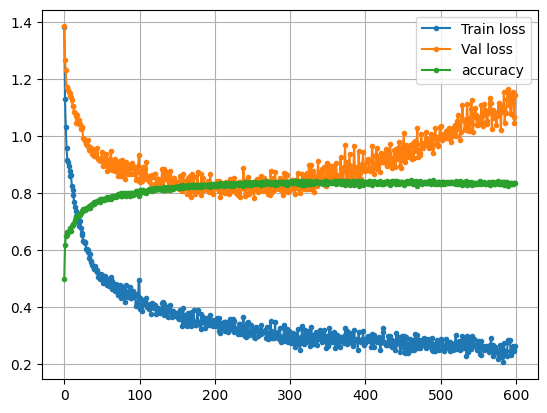

In [10]:

plt.plot(loss_train,".-",label="Train loss")
plt.plot(loss_val,".-",label="Val loss")
plt.plot(acc_val,".-",label="accuracy")
# plt.xlim([0,250])
# plt.ylim([0,1])
plt.grid()
plt.legend()


In [56]:
model.eval()
acc = 0
i = 0
for batch in data_loader:
    if i >= eval_iters:
        break
    X = torch.tensor(batch['input']).to(device, dtype= torch.int32)
    Y = torch.tensor(batch['target']).to(device)
    err_probs, _ = model(X)
    pred = (err_probs > 0.5).to(Y)
    # print(err_probs.shape, Y.shape)
    acc += torch.sum(pred == Y, dim=(0,1))/Y.shape[0]/2
    i += 1
acc /= i

model.train()
print(acc.item())

0.9437000155448914


In [16]:
# PATH = f"models/enc_pad_eos_{n_layer}_lr_{learning_rate:.4f}_dtrained_{d}.pt"
PATH = f"models/enc_eos_original_{n_layer}_lr_{learning_rate:.4f}_dtrained_{d_max}.pt"

# saving the state
# model.to(device)
# torch.save(model.state_dict(), PATH)
checkpoint = {
"epoch": 100,
"model_state": model.state_dict(),
"optim_state": optimizer.state_dict()
}
# print(optimizer.state_dict())
# FILE = "checkpoint.pth"
torch.save(checkpoint, PATH)

In [4]:
d_max = 9 # must be an odd number
block_size = 400 # what is the maximum context length for predictions?
n_embd = 128 #384
n_head = 4
n_layer = 6
dropout = 0.2
vocab_size = 4

learning_rate = 3e-4
# FILE = f"models/enc_pad_{n_layer}_lr_{learning_rate:.4f}_dtrained_{d}.pt"
# FILE = f"models/enc_pad_eos_{n_layer}_lr_{learning_rate:.4f}_dtrained_{d}.pt"
FILE = f"models/enc_eos_original_{n_layer}_lr_{learning_rate:.4f}_dtrained_{d_max}.pt"

device = "cuda" if torch.cuda.is_available() else "cpu"

model = Encoder()

optimizer = torch.optim.AdamW(model.parameters(), lr=0)
# optimizer = torch.optim.SGD(model.parameters(), lr=0)
checkpoint = torch.load(FILE)
model.load_state_dict(checkpoint['model_state'])
optimizer.load_state_dict(checkpoint['optim_state'])
epoch = checkpoint['epoch']

# model.load_state_dict(torch.load(PATH))
model.to(device)

Encoder(
  (token_embedding_table): Embedding(4, 128)
  (position_embedding_table): Embedding(400, 128)
  (blocks): Sequential(
    (0): Block(
      (sa): MultiHeadAttention(
        (heads): ModuleList(
          (0-3): 4 x Head(
            (key): Linear(in_features=128, out_features=32, bias=False)
            (query): Linear(in_features=128, out_features=32, bias=False)
            (value): Linear(in_features=128, out_features=32, bias=False)
            (dropout): Dropout(p=0.2, inplace=False)
          )
        )
        (proj): Linear(in_features=128, out_features=128, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (ffwd): FeedFoward(
        (net): Sequential(
          (0): Linear(in_features=128, out_features=512, bias=True)
          (1): ReLU()
          (2): Linear(in_features=512, out_features=128, bias=True)
          (3): Dropout(p=0.2, inplace=False)
        )
      )
      (ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      

In [11]:
def collate_fn(examples):
    input = [example['input'] for example in examples]
    target = [example['target'] for example in examples]
    return {'input': input, 'target': target}

d = 7
p_err =  0.1
dataset = load_dataset("json", data_files={
        # 'test' : f"datasets/test_enc_pad_{d_max}_d_{d}_p_{p_err:.2f}.json"
        'test' : f"datasets/test_enc_pad_d_{d}_p_{p_err:.2f}.json"
    })
data_loader_test = DataLoader(dataset["test"], batch_size=batch_size, collate_fn=collate_fn)


Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 1135.13it/s]
Generating test split: 1000 examples [00:00, 54495.54 examples/s]


In [12]:
for batch in data_loader_test:
    x = torch.tensor(batch['input']).to(device, dtype= torch.int32)
    model(x)
    break

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0', dtype=torch.int32)
tensor([0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0],
       device='cuda:0', dtype=torch.int32)
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0', dtype=torch.int32)
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0', dtype=torch.int32)


In [11]:
# d = 5 # must be an odd number
# n_hidden = [500, 512, 512]
# learning_rate = [1e-2,1e-2,1e-3]
# device = "cuda" if torch.cuda.is_available() else "cpu"
def collate_fn(examples):
    input = [example['input'] for example in examples]
    target = [example['target'] for example in examples]
    return {'input': input, 'target': target}


# d_max = 7
batch_size = 1000
p_err_list = torch.arange(0.01,0.31,0.01)
d_list = torch.arange(3,12,2)
acc = torch.zeros((p_err_list.shape[0],len(d_list)))
for i_d,d in enumerate(d_list):
    # model = load_model(d,n_hidden[i_d],learning_rate)
    # FILE = f"models/d_{d}_nh_{n_hidden[i_d]}_lr_{learning_rate[i_d]:.3f}.pt"

    # model = MLP(d, n_hidden[i_d])

    # optimizer = torch.optim.AdamW(model.parameters(), lr=0)
    # checkpoint = torch.load(FILE)
    # model.load_state_dict(checkpoint['model_state'])
    # optimizer.load_state_dict(checkpoint['optim_state'])
    # epoch = checkpoint['epoch']

    # # model.load_state_dict(torch.load(PATH))
    # model.to(device)
    model.eval()
    for i_p, p_err in enumerate(p_err_list):
        dataset = load_dataset("json", data_files={
                # 'test' : f"datasets/test_enc_pad_{d_max}_d_{d}_p_{p_err:.2f}.json"
                'test' : f"datasets/test_eos_original_d_{d}_p_{p_err:.2f}.json"
            })
        data_loader_test = DataLoader(dataset["test"], batch_size=batch_size, collate_fn=collate_fn)

        with torch.no_grad():
            for i_b, batch in enumerate(data_loader_test):
                X = torch.tensor(batch['input']).to(device, dtype= torch.int32)
                Y = torch.tensor(batch['target']).to(device)
                err_probs, _ = model(X)
                pred = (err_probs > 0.5).to(Y)
                acc[i_p,i_d] += torch.sum(pred == Y, dim=(0,1)).item()/Y.shape[0]/2
            # print(i_b)
            acc[i_p,i_d] /= (i_b+1)

# model.train()
# del model


Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 610.61it/s]
Generating test split: 10000 examples [00:00, 175114.35 examples/s]
Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 837.86it/s]
Generating test split: 10000 examples [00:00, 213776.96 examples/s]
Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 1007.04it/s]
Generating test split: 10000 examples [00:00, 189614.20 examples/s]
Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 1127.80it/s]
Generating test split: 10000 examples [00:00, 225898.57 examples/s]
Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 939.58it/s]
Generating test split: 10000 examples [00:00, 172180.67 examples/s]
Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 425.08it/s]
Generating test split: 4141 examples [00:00, 122188.54 examples/s]


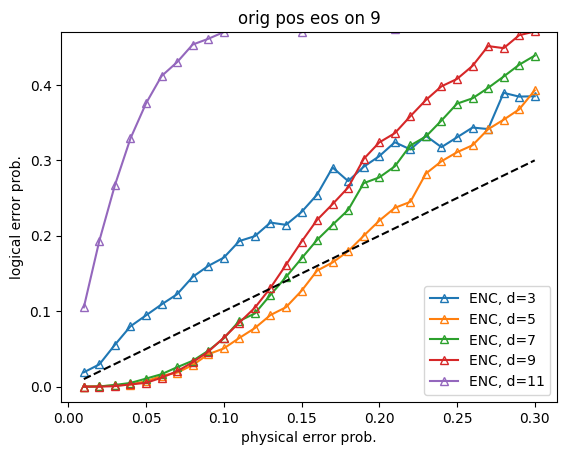

In [13]:
def mwpm_file_reader(d):
    fname = f"results/mwpm_sweep_d_{d}.json"
    f = open(fname)
    data = json.load(f)
    f.close()
    return data['p_err'], data['logical_err']

for i_d, d in enumerate(d_list):
    # p_err_list,logical_err_mwpm = mwpm_file_reader(d)
    # plt.plot(p_err_list,logical_err_mwpm,".--", color= f"C{i_d}",label=f"MWPM, d={d}")
    plt.plot(p_err_list,1-acc[:,i_d],"^-", color= f"C{i_d}",markerfacecolor="None",label=f"ENC, d={d}")

plt.plot(p_err_list,p_err_list,"k--")
plt.title(f"orig pos eos on {d_max}")
plt.ylim([-0.02,0.47])
# plt.yscale("log")
plt.xlabel("physical error prob.")
plt.ylabel("logical error prob.")
plt.legend()


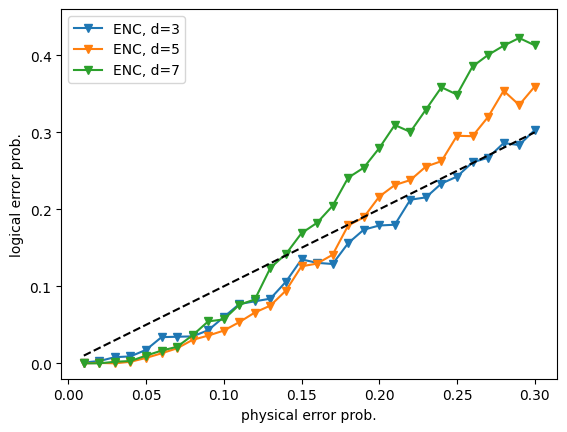

In [12]:
def mwpm_file_reader(d):
    fname = f"results/mwpm_sweep_d_{d}.json"
    f = open(fname)
    data = json.load(f)
    f.close()
    return data['p_err'], data['logical_err']

for i_d, d in enumerate(d_list):
    # p_err_list,logical_err_mwpm = mwpm_file_reader(d)
    # plt.plot(p_err_list,logical_err_mwpm,".--", color= f"C{i_d}",label=f"MWPM, d={d}")
    plt.plot(p_err_list,1-acc[:,i_d],"v-", color= f"C{i_d}",label=f"ENC, d={d}")

plt.plot(p_err_list,p_err_list,"k--")
plt.ylim([-0.02,0.46])
plt.xlabel("physical error prob.")
plt.ylabel("logical error prob.")
plt.legend()


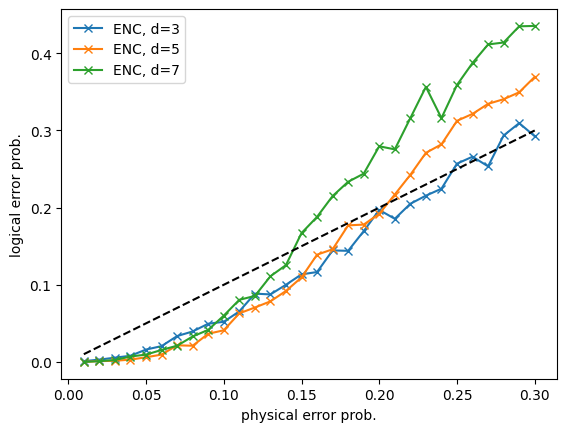

In [10]:
for i_d, d in enumerate(d_list):
    plt.plot(p_err_list,1-acc[:,i_d],"x-", color= f"C{i_d}",label=f"ENC, d={d}")

plt.plot(p_err_list,p_err_list,"k--")
plt.xlabel("physical error prob.")
plt.ylabel("logical error prob.")
plt.legend()


## class accuracy

In [18]:
# d = 5 # must be an odd number
# n_hidden = [500, 512, 512]
# learning_rate = [1e-2,1e-2,1e-3]
# device = "cuda" if torch.cuda.is_available() else "cpu"
def collate_fn(examples):
    input = [example['input'] for example in examples]
    target = [example['target'] for example in examples]
    return {'input': input, 'target': target}


# d_max = 7
batch_size = 1000
p_err_list = torch.arange(0.01,0.31,0.01)
d_list = torch.arange(5,10,2)
acc = torch.zeros((p_err_list.shape[0],len(d_list)))
for i_d,d in enumerate(d_list):

    model.eval()
    for i_p, p_err in enumerate(p_err_list):
        dataset = load_dataset("json", data_files={
                # 'test' : f"datasets/test_enc_pad_{d_max}_d_{d}_p_{p_err:.2f}.json"
                'test' : f"datasets/test_enc_pad_d_{d}_p_{p_err:.2f}.json"
            })

        # d1 = dataset["test"].filter(lambda example: example['target'][0]+example['target'][1]>0 )
        d1 = dataset["test"].filter(lambda example: example['target'][0]+example['target'][1]==0 )
        data_loader_test = DataLoader(d1, batch_size=batch_size, collate_fn=collate_fn)

        with torch.no_grad():
            for i_b, batch in enumerate(data_loader_test):
                X = torch.tensor(batch['input']).to(device, dtype= torch.int32)
                Y = torch.tensor(batch['target']).to(device)
                err_probs, _ = model(X)
                pred = (err_probs > 0.5).to(Y)
                acc[i_p,i_d] += torch.sum(pred == Y, dim=(0,1)).item()/Y.shape[0]/2
            # print(i_b)
            acc[i_p,i_d] /= (i_b+1)

# model.train()
# del model


Filter:  90%|█████████ | 9000/10000 [00:00<00:00, 11423.25 examples/s]


KeyboardInterrupt: 

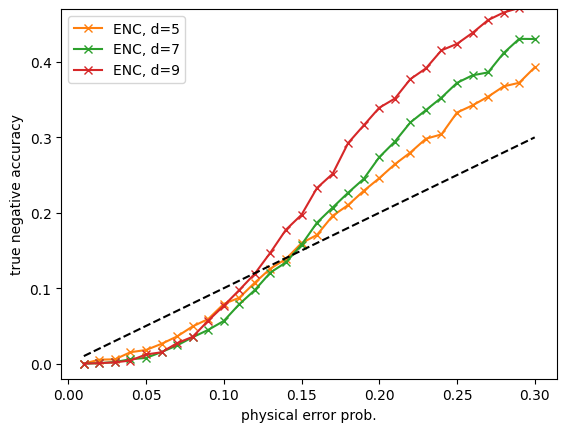

In [16]:
for i_d, d in enumerate(d_list):
    plt.plot(p_err_list,1-acc[:,i_d],"x-", color= f"C{i_d+1}",label=f"ENC, d={d}")

plt.plot(p_err_list,p_err_list,"k--")
plt.ylim([-0.02,0.47])
plt.xlabel("physical error prob.")
plt.ylabel("true negative accuracy") # error happened
plt.legend()


In [ ]:
for i_d, d in enumerate(d_list):
    plt.plot(p_err_list,1-acc[:,i_d],"v-", color= f"C{i_d+1}",label=f"ENC, d={d}")

plt.plot(p_err_list,p_err_list,"k--")
plt.ylim([-0.02,0.47])
plt.xlabel("physical error prob.")
plt.ylabel("true positive accuracy") # error did not happen
plt.legend()


## finetuning

In [4]:
d = 9 # must be an odd number
block_size = 400 # what is the maximum context length for predictions?
n_embd = 128 #384
n_head = 4
n_layer = 6
dropout = 0.2
vocab_size = 4

learning_rate = 3e-4
# FILE = f"models/enc_pad_{n_layer}_lr_{learning_rate:.4f}_dtrained_{d}.pt"
# FILE = f"models/enc_pad_eos_{n_layer}_lr_{learning_rate:.4f}_dtrained_{d}.pt"
FILE = f"models/enc_pad_no_pad_eos_{n_layer}_lr_{learning_rate:.4f}_dtrained_{d}.pt"

device = "cuda" if torch.cuda.is_available() else "cpu"

model = Encoder()

optimizer = torch.optim.AdamW(model.parameters(), lr=0)
# optimizer = torch.optim.SGD(model.parameters(), lr=0)
checkpoint = torch.load(FILE)
model.load_state_dict(checkpoint['model_state'])
optimizer.load_state_dict(checkpoint['optim_state'])
epoch = checkpoint['epoch']

# model.load_state_dict(torch.load(PATH))
model.to(device)

Encoder(
  (token_embedding_table): Embedding(4, 128)
  (position_embedding_table): Embedding(400, 128)
  (blocks): Sequential(
    (0): Block(
      (sa): MultiHeadAttention(
        (heads): ModuleList(
          (0-3): 4 x Head(
            (key): Linear(in_features=128, out_features=32, bias=False)
            (query): Linear(in_features=128, out_features=32, bias=False)
            (value): Linear(in_features=128, out_features=32, bias=False)
            (dropout): Dropout(p=0.2, inplace=False)
          )
        )
        (proj): Linear(in_features=128, out_features=128, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (ffwd): FeedFoward(
        (net): Sequential(
          (0): Linear(in_features=128, out_features=512, bias=True)
          (1): ReLU()
          (2): Linear(in_features=512, out_features=128, bias=True)
          (3): Dropout(p=0.2, inplace=False)
        )
      )
      (ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      

In [6]:
# hyperparameters
batch_size = 1200 # how many independent sequences will we process in parallel?
max_iters = 5000
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# ------------

d = 13 # must be an odd number
model = Encoder()
m = model.to(device)

# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters()), 'parameters')

p_err_train = 0.1
p_err_val = 0.15
dataset = load_dataset("json", data_files={
        # 'train' : f"datasets/train_enc_pad_{d_max}_d_{d}_p_{p_err_train:.2f}.json",
        # 'val' : f"datasets/val_enc_pad_{d_max}_d_{d}_p_{p_err_val:.2f}.json",
        'train' : f"datasets/train_enc_pad_d_{d}_p_{p_err_train:.2f}.json",
        'val' : f"datasets/val_enc_pad_d_{d}_p_{p_err_val:.2f}.json"
    })

def collate_fn(examples):
    input = [example['input'] for example in examples]
    target = [example['target'] for example in examples]
    return {'input': input, 'target': target}

data_loader = DataLoader(dataset["train"], batch_size=batch_size, collate_fn=collate_fn)
data_loader_val = DataLoader(dataset["val"], batch_size=batch_size, collate_fn=collate_fn)
# print(dataset["val"])

1239554 parameters


In [7]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    # for split in ['train', 'val']:
    losses = torch.zeros(eval_iters)
    i = 0
    # data_loader_loss = DataLoader(dataset["train"], batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
    for batch in data_loader:
        if i >= eval_iters:
            break
        # X = torch.tensor(batch['input']).to(device)
        X = torch.tensor(batch['input']).to(device, dtype= torch.int32)
        Y = torch.tensor(batch['target']).to(device)
        err_probs, loss = model(X,Y)

        losses[i] = loss.item()
        i += 1
    out["train"] = losses.mean()

    i = 0
    out["val"] = 0
    for batch in data_loader_val:
        # X = torch.tensor(batch['input']).to(device)
        X = torch.tensor(batch['input']).to(device, dtype= torch.int32)
        Y = torch.tensor(batch['target']).to(device)
        err_probs, loss = model(X,Y)

        out["val"] += loss.item()
        i += 1
    out["val"] /= i
    
    model.train()
    return out

def estimate_accuracy():
    model.eval()
    i = 0
    acc = 0
    for batch in data_loader_val:
        # X = torch.tensor(batch['input']).to(device)
        X = torch.tensor(batch['input']).to(device, dtype= torch.int32)
        Y = torch.tensor(batch['target']).to(device)
        err_probs, _ = model(X)
        pred = (err_probs > 0.5).to(Y)
        # print(err_probs.shape, Y.shape)
        acc += torch.sum(pred == Y, dim=(0,1))/Y.shape[0]/2
        i += 1
    acc /= i
    
    model.train()
    return acc.item()


In [8]:
learning_rate = 3e-4
# # create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

eval_interval = 100
eval_iters =  10
num_epochs = 100

loss_train = []
loss_val = []
acc_val = []
for epoch in range(num_epochs):
    iter = 0
    # if epoch % 10 == 0:
    # # if iter % eval_interval == 0:
    #     losses = estimate_loss()
    #     acc = estimate_accuracy()
    #     print(f"epoch {epoch}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}, val acc {acc:.4f}")
    #     loss_train.append(losses['train'])
    #     loss_val.append(losses['val'])
    #     acc_val.append(acc)

    # data_loader = DataLoader(dataset["train"], batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
    for i_b, batch in enumerate(data_loader):
        # if i_b>= eval_iters:
        #     break
        # # every once in a while evaluate the loss on train and val sets
        # if epoch % 10 == 0:
        if iter % eval_interval == 0:
            losses = estimate_loss()
            acc = estimate_accuracy()
            print(f"epoch, step {epoch, iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}, val acc {acc:.4f}")
            loss_train.append(losses['train'])
            loss_val.append(losses['val'])
            acc_val.append(acc)
        X = torch.tensor(batch['input']).to(device, dtype= torch.int32)
        Y = torch.tensor(batch['target']).to(device)
        err_probs, loss = model(X, Y)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        iter += 1



epoch, step (0, 0): train loss 1.3865, val loss 1.3864, val acc 0.4746
epoch, step (1, 0): train loss 1.3597, val loss 1.4041, val acc 0.5254
epoch, step (2, 0): train loss 1.3591, val loss 1.3995, val acc 0.5254
epoch, step (3, 0): train loss 1.3591, val loss 1.3988, val acc 0.5254
epoch, step (4, 0): train loss 1.3589, val loss 1.3976, val acc 0.5254
epoch, step (5, 0): train loss 1.3552, val loss 1.3938, val acc 0.5254
epoch, step (6, 0): train loss 1.3269, val loss 1.3791, val acc 0.5254
epoch, step (7, 0): train loss 1.3521, val loss 1.3913, val acc 0.5254
epoch, step (8, 0): train loss 1.3412, val loss 1.3819, val acc 0.5163
epoch, step (9, 0): train loss 1.3091, val loss 1.3748, val acc 0.5233
epoch, step (10, 0): train loss 1.2954, val loss 1.3752, val acc 0.5294
epoch, step (11, 0): train loss 1.2842, val loss 1.3750, val acc 0.5281
epoch, step (12, 0): train loss 1.2784, val loss 1.3750, val acc 0.5354
epoch, step (13, 0): train loss 1.2810, val loss 1.3730, val acc 0.5283
ep

In [1]:
# d = 5 # must be an odd number
# n_hidden = [500, 512, 512]
# learning_rate = [1e-2,1e-2,1e-3]
# device = "cuda" if torch.cuda.is_available() else "cpu"
def collate_fn(examples):
    input = [example['input'] for example in examples]
    target = [example['target'] for example in examples]
    return {'input': input, 'target': target}


# d_max = 7
batch_size = 1000
p_err_list = torch.arange(0.01,0.31,0.01)
d_list = torch.arange(3,10,2)
acc = torch.zeros((p_err_list.shape[0],len(d_list)))
for i_d,d in enumerate(d_list):

    model.eval()
    for i_p, p_err in enumerate(p_err_list):
        dataset = load_dataset("json", data_files={
                # 'test' : f"datasets/test_enc_pad_{d_max}_d_{d}_p_{p_err:.2f}.json"
                'test' : f"datasets/test_enc_pad_d_{d}_p_{p_err:.2f}.json"
            })

        # d1 = dataset["test"].filter(lambda example: example['target'][0]+example['target'][1]>0 )
        d1 = dataset["test"]#.filter(lambda example: example['target'][0]+example['target'][1]==0 )
        data_loader_test = DataLoader(d1, batch_size=batch_size, collate_fn=collate_fn)

        with torch.no_grad():
            for i_b, batch in enumerate(data_loader_test):
                X = torch.tensor(batch['input']).to(device, dtype= torch.int32)
                Y = torch.tensor(batch['target']).to(device)
                err_probs, _ = model(X)
                pred = (err_probs > 0.5).to(Y)
                acc[i_p,i_d] += torch.sum(pred == Y, dim=(0,1)).item()/Y.shape[0]/2
            # print(i_b)
            acc[i_p,i_d] /= (i_b+1)

# model.train()
# del model


NameError: name 'torch' is not defined

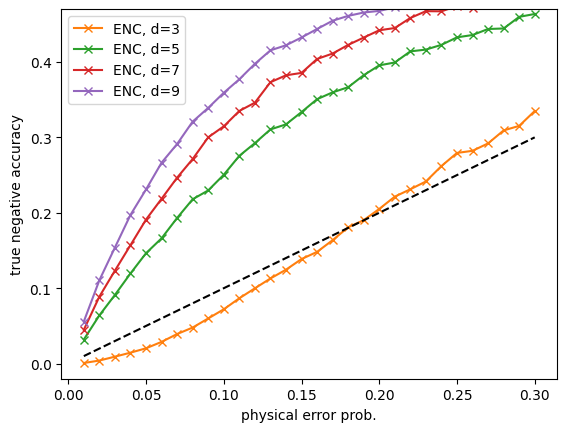

In [11]:
for i_d, d in enumerate(d_list):
    plt.plot(p_err_list,1-acc[:,i_d],"x-", color= f"C{i_d+1}",label=f"ENC, d={d}")

plt.plot(p_err_list,p_err_list,"k--")
plt.ylim([-0.02,0.47])
plt.xlabel("physical error prob.")
plt.ylabel("true negative accuracy") # error happened
plt.legend()
